# CS M148 Final Project: Song Genre Predictor

## Exploratory Data Analysis (EDA), Visualization, and Splitting into Train/Test Sets

In [1]:
import pandas as pd
import numpy as np

In [2]:
# load the dataset
df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")

### Data Cleaning

In [3]:
# remove all rows with missing values
df.dropna(inplace=True) 

# remove all duplicate values based on track name and artist name
df.drop_duplicates(subset=['track_name', 'artists'], inplace=True)

### Genre Mapping

In [4]:
genres = ['acoustic' 'afrobeat' 'alt-rock' 'alternative' 'ambient' 'anime'
    'black-metal' 'bluegrass' 'blues' 'brazil' 'breakbeat' 'british'
    'cantopop' 'chicago-house' 'children' 'chill' 'classical' 'club' 'comedy'
    'country' 'dance' 'dancehall' 'death-metal' 'deep-house' 'detroit-techno'
    'disco' 'disney' 'drum-and-bass' 'dub' 'dubstep' 'edm' 'electro'
    'electronic' 'emo' 'folk' 'forro' 'french' 'funk' 'garage' 'german'
    'gospel' 'goth' 'grindcore' 'groove' 'grunge' 'guitar' 'happy'
    'hard-rock' 'hardcore' 'hardstyle' 'heavy-metal' 'hip-hop' 'honky-tonk'
    'house' 'idm' 'indian' 'indie-pop' 'indie' 'industrial' 'iranian'
    'j-dance' 'j-idol' 'j-pop' 'j-rock' 'jazz' 'k-pop' 'kids' 'latin'
    'latino' 'malay' 'mandopop' 'metal' 'metalcore' 'minimal-techno' 'mpb'
    'new-age' 'opera' 'pagode' 'party' 'piano' 'pop-film' 'pop' 'power-pop'
    'progressive-house' 'psych-rock' 'punk-rock' 'punk' 'r-n-b' 'reggae'
    'reggaeton' 'rock-n-roll' 'rock' 'rockabilly' 'romance' 'sad' 'salsa'
    'samba' 'sertanejo' 'show-tunes' 'singer-songwriter' 'ska' 'sleep'
    'songwriter' 'soul' 'spanish' 'study' 'swedish' 'synth-pop' 'tango'
    'techno' 'trance' 'trip-hop' 'turkish' 'world-music'
 ]

genre_mapping = {
    "rock_alt_metal": [
        "alt-rock", "alternative", "black-metal", "death-metal", "emo", "goth",
        "grindcore", "grunge", "hard-rock", "hardcore", "heavy-metal", "metal",
        "metalcore", "psych-rock", "punk-rock", "punk", "rock", "rock-n-roll", "hardstyle", "j-rock", "rockabilly"
    ],
    "pop_indie": [
        "pop", "power-pop", "pop-film", "indie", "indie-pop", "j-pop", "k-pop",
        "cantopop", "mandopop", "synth-pop"
    ],
    "electronic_dance": [
        "edm", "dance", "electro", "electronic", "trance", "techno",
        "detroit-techno", "chicago-house", "progressive-house", "deep-house",
        "house", "minimal-techno", "dubstep", "drum-and-bass", "breakbeat",
        "dub", "idm", "disco", "garage", "groove"
    ],
    "hiphop_rnb": [
        "hip-hop", "r-n-b", "soul", "funk"
    ],
    "jazz_classical": [
        "jazz", "blues", "classical", "piano"
    ],
    "country_folk": [
        "country", "folk", "bluegrass", "honky-tonk", "singer-songwriter",
        "songwriter", "acoustic"
    ],
    "latin_world": [
        "latin", "latino", "afrobeat", "brazil", "mpb", "samba", "salsa", "tango",
        "pagode", "forro", "sertanejo", "reggaeton", "indian", "iranian",
        "turkish", "french", "german", "british", "swedish", "malay", "world-music"
    ],
    "reggae": [
        "reggae", "dancehall"
    ],
    "ambient_chill": [
        "ambient", "chill", "new-age", "trip-hop"
    ],
    "thematic": [
        "anime", "children", "comedy", "club", "disney", "gospel", "guitar",
        "happy", "industrial", "j-dance", "j-idol", "kids", "opera", "party",
        "romance", "sad", "show-tunes", "ska", "sleep", "spanish", "study"
    ]
}


flattened_mapping = {genre: category for category, subgenres in genre_mapping.items() for genre in subgenres}

df['track_genre'] = df['track_genre'].apply(lambda x: flattened_mapping[x])



In [5]:
print(len(df['track_genre'].unique()))

10


### Distributions of Modes for Each Genre

track_genre
ambient_chill       0.594100
country_folk        0.846171
electronic_dance    0.543395
hiphop_rnb          0.543807
jazz_classical      0.713617
latin_world         0.620362
pop_indie           0.671976
reggae              0.517518
rock_alt_metal      0.619785
thematic            0.667246
Name: mode, dtype: float64


<Axes: xlabel='track_genre'>

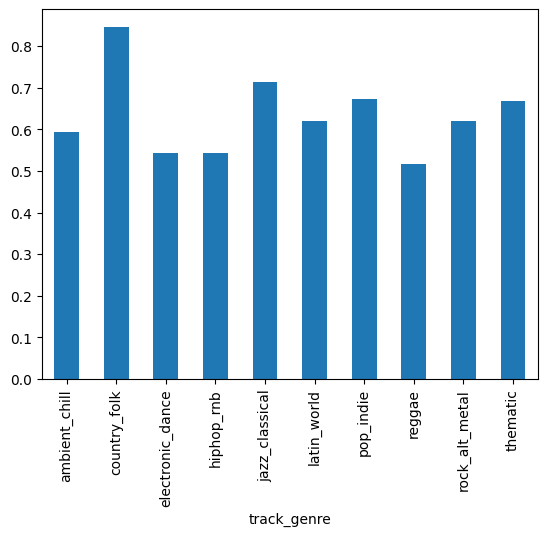

In [6]:
# get the number of genres in the dataset

# Group the dataset by genre, and get the percentage of tracks that has Mode value of 1
print(df.groupby('track_genre')['mode'].mean())

# visualize the percentage of modes of each genre, by plotting a histogram of the track genres
df.groupby('track_genre')['mode'].mean().plot(kind='bar')

# Logistic Regression on Mode Feature

In [7]:
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.utils import resample
import matplotlib.pyplot as plt


# plot confusion matrix to identify best predictors
df['mode'] = df['mode'].astype(int)
numeric_df = df.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()
correlation_matrix

,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
Unnamed: 0,1.000000,0.032008,-0.029592,-0.024719,-0.064272,-0.008776,-0.044169,-0.006544,-0.093474,0.088671,-0.050356,0.047232,0.037897,-0.035741,-0.028832
popularity,0.032008,1.000000,-0.053321,0.087245,-0.000871,0.004427,0.090162,-0.004927,-0.064913,-0.032143,-0.174509,-0.028974,0.011323,0.001891,0.038559
duration_ms,-0.029592,-0.053321,1.000000,-0.060165,0.058394,0.011665,0.002400,-0.035648,-0.063688,-0.106275,0.109759,0.005601,-0.140941,0.024062,0.021333
danceability,-0.024719,0.087245,-0.060165,1.000000,0.134654,0.032583,0.264934,-0.059299,0.108294,-0.167829,-0.191535,-0.132784,0.492132,-0.015470,0.206450
energy,-0.064272,-0.000871,0.058394,0.134654,1.000000,0.042777,0.761042,-0.069535,0.139823,-0.731108,-0.186446,0.190931,0.253953,0.260840,0.181097
key,-0.008776,0.004427,0.011665,0.032583,0.042777,1.000000,0.033895,-0.145019,0.013293,-0.041848,-0.003634,-0.002775,0.023814,0.005688,0.014993
loudness,-0.044169,0.090162,0.002400,0.264934,0.761042,0.033895,1.000000,-0.035465,0.054019,-0.582132,-0.434393,0.080270,0.289951,0.234033,0.193658
mode,-0.006544,-0.004927,-0.035648,-0.059299,-0.069535,-0.145019,-0.035465,1.000000,-0.035567,0.084144,-0.050497,0.018166,0.024349,-0.001603,-0.023201
speechiness,-0.093474,-0.064913,-0.063688,0.108294,0.139823,0.013293,0.054019,-0.035567,1.000000,0.012316,-0.106998,0.231626,0.035074,-0.003208,-0.011022
acousticness,0.088671,-0.032143,-0.106275,-0.167829,-0.731108,-0.041848,-0.582132,0.084144,0.012316,1.000000,0.095258,-0.016355,-0.101706,-0.223598,-0.173610


In [8]:
counts = df['mode'].value_counts()
print("Number of 1s:", counts.get(1, 0))
print("Number of 0s:", counts.get(0, 0))

Number of 1s: 51437
Number of 0s: 29906


Number of iterations used by the solver: [3892]
Confusion Matrix:
 [[ 6393 14455]
 [ 3971 32121]]
Accuracy: 0.6763962065331929
Prediction Error: 0.3236037934668071
True Positive Rate (TPR): 0.889975617865455
True Negative Rate (TNR): 0.30664811972371453


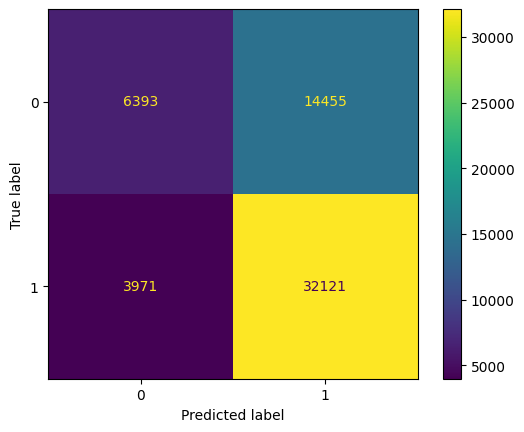

In [9]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

scaler = StandardScaler()
lr = LogisticRegression(C=0.05, max_iter=10000)

# get all numeric columns
X = df.select_dtypes(include=['int64', 'float64']).drop(columns=['mode'])
X_scaled = scaler.fit_transform(X)
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X_scaled)
y = df['mode']

x_train, x_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3)
lr.fit(x_train, y_train)
print("Number of iterations used by the solver:", lr.n_iter_)

y_pred_train = lr.predict(x_train)

conf_matrix = confusion_matrix(y_train, y_pred_train)
tn, fp, fn, tp = conf_matrix.ravel()

accuracy = accuracy_score(y_train, y_pred_train)
prediction_error = 1 - accuracy

true_positive_rate = tp / (tp + fn)
true_negative_rate = tn / (tn + fp)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Prediction Error:", prediction_error)
print("True Positive Rate (TPR):", true_positive_rate)
print("True Negative Rate (TNR):", true_negative_rate)

# visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lr.classes_)
disp.plot()
plt.show()

In [10]:
counts = y_train.value_counts()
print("Number of 1s:", counts.get(1, 0))
print("Number of 0s:", counts.get(0, 0))

Number of 1s: 36092
Number of 0s: 20848


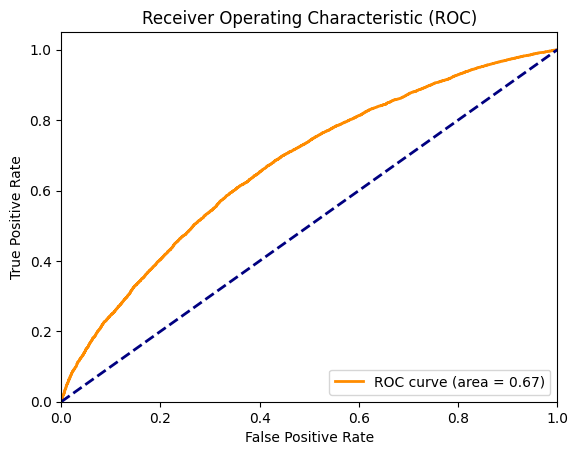

In [11]:
# plot the roc curve
y_pred = lr.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# visualize the roc curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [12]:
# use cross-validation on validation set
cv = StratifiedKFold(n_splits=5, shuffle=True)

# compute predicted probabilities
y_pred_prob = cross_val_predict(lr, x_test, y_test, cv=cv, method="predict_proba")

auc_scores = cross_val_score(lr, x_test, y_test, cv=cv, scoring='roc_auc')
accuracy_scores = cross_val_score(lr, x_test, y_test, cv=cv, scoring='accuracy')

print("AUC scores for each fold:", auc_scores)
print("Mean AUC:", np.mean(auc_scores))
print("Accuracy for each fold:", accuracy_scores)
print("Mean Accuracy:", np.mean(accuracy_scores))

AUC scores for each fold: [0.65165146 0.65316503 0.65150868 0.65150031 0.66634299]
Mean AUC: 0.6548336912193656
Accuracy for each fold: [0.657857   0.63757427 0.65970088 0.64692623 0.65122951]
Mean Accuracy: 0.6506575765514323


# Neural Network for Genre Prediction

In [13]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [16]:
df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")
# remove all rows with missing values
df.dropna(inplace=True) 

# remove all duplicate values based on track name and artist name
df.drop_duplicates(subset=['track_name', 'artists'], inplace=True)
# create a dictionary with keys being genres and the values being each genre
genres = [genre for genre, _ in genre_mapping.items()]
genre_encoding = {genre: i for i, genre in enumerate(genres)}

print(genre_encoding)

df['track_genre'] = df['track_genre'].apply(lambda x: flattened_mapping[x])


# genre_encoded
df_encoded = df
df_encoded['track_genre'] = df_encoded['track_genre'].apply(lambda x: genre_encoding[x])

# shuffle the dataframe
df_encoded = df_encoded.sample(frac=1).reset_index(drop=True)

# separate the features and the target variable (track_genre) and convert to tensors
X = torch.tensor(df_encoded.drop(columns=['track_genre']).select_dtypes(include=[np.number]).to_numpy(), dtype=torch.float32)
y = torch.tensor(df_encoded['track_genre'].to_numpy(), dtype=torch.long)

print(X.shape, y.shape)

{'rock_alt_metal': 0, 'pop_indie': 1, 'electronic_dance': 2, 'hiphop_rnb': 3, 'jazz_classical': 4, 'country_folk': 5, 'latin_world': 6, 'reggae': 7, 'ambient_chill': 8, 'thematic': 9}
torch.Size([81343, 15]) torch.Size([81343])


### create dataset, split

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataloader

In [17]:
class Track_dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [18]:
# split the dataset into train, valid, and test sets
train_size = int(0.7 * len(df))
valid_size = int(0.15 * len(df))
test_size = len(df) - train_size - valid_size
X_train, X_valid, X_test = torch.split(X, [train_size, valid_size, test_size])
print(X_train.shape, X_valid.shape, X_test.shape)
y_train, y_valid, y_test = torch.split(y, [train_size, valid_size, test_size])
print(y_train.shape, y_valid.shape, y_test.shape)


train_dataset = Track_dataset(X_train, y_train)
valid_dataset = Track_dataset(X_valid, y_valid)
test_dataset = Track_dataset(X_test, y_test)

torch.Size([56940, 15]) torch.Size([12201, 15]) torch.Size([12202, 15])
torch.Size([56940]) torch.Size([12201]) torch.Size([12202])


### define model

In [19]:
# 3-layer neural network
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(15, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### train the model

In [20]:
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# train the model, record the validation loss for the plots
n_epochs = 50
train_loss_hist, valid_loss_hist = [], []
for epoch in range(n_epochs):
    tot_train_loss, tot_valid_loss = 0, 0

    model.train()
    for x, y in tqdm(train_loader):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        tot_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        tot_valid_loss = 0
        for x, y in valid_loader:
            y_pred = model(x)
            valid_loss = criterion(y_pred, y)
            tot_valid_loss += valid_loss.item()
        print(f"Epoch {epoch}: Validation Loss: {tot_valid_loss/len(valid_loader)}")
    train_loss_hist.append(tot_train_loss/len(train_loader))
    valid_loss_hist.append(tot_valid_loss/len(valid_loader))

100%|██████████| 890/890 [00:00<00:00, 1463.96it/s]


Epoch 0: Validation Loss: 12.476650732349976


100%|██████████| 890/890 [00:00<00:00, 1778.71it/s]


Epoch 1: Validation Loss: 11.66047204601827


100%|██████████| 890/890 [00:00<00:00, 1596.04it/s]


Epoch 2: Validation Loss: 8.821208057603286


100%|██████████| 890/890 [00:00<00:00, 1794.63it/s]


Epoch 3: Validation Loss: 9.534416151296407


100%|██████████| 890/890 [00:00<00:00, 1769.43it/s]


Epoch 4: Validation Loss: 8.041674344327438


100%|██████████| 890/890 [00:00<00:00, 1657.02it/s]


Epoch 5: Validation Loss: 8.683762240784331


100%|██████████| 890/890 [00:00<00:00, 1786.11it/s]


Epoch 6: Validation Loss: 12.555889536573


100%|██████████| 890/890 [00:00<00:00, 1782.21it/s]


Epoch 7: Validation Loss: 7.749826940566457


100%|██████████| 890/890 [00:00<00:00, 1793.01it/s]


Epoch 8: Validation Loss: 9.72172783057727


100%|██████████| 890/890 [00:00<00:00, 1814.00it/s]


Epoch 9: Validation Loss: 6.537413127759364


100%|██████████| 890/890 [00:00<00:00, 1797.37it/s]


Epoch 10: Validation Loss: 6.46994208041286


100%|██████████| 890/890 [00:00<00:00, 1795.61it/s]


Epoch 11: Validation Loss: 9.67254412236638


100%|██████████| 890/890 [00:00<00:00, 1811.89it/s]


Epoch 12: Validation Loss: 3.6566856381780815


100%|██████████| 890/890 [00:00<00:00, 1765.69it/s]


Epoch 13: Validation Loss: 10.79510545231285


100%|██████████| 890/890 [00:00<00:00, 1782.00it/s]


Epoch 14: Validation Loss: 4.772888466949862


100%|██████████| 890/890 [00:00<00:00, 1805.56it/s]


Epoch 15: Validation Loss: 4.270214583861266


100%|██████████| 890/890 [00:00<00:00, 1534.18it/s]


Epoch 16: Validation Loss: 3.2921210608557256


100%|██████████| 890/890 [00:00<00:00, 1798.25it/s]


Epoch 17: Validation Loss: 7.138966273262863


100%|██████████| 890/890 [00:00<00:00, 1765.67it/s]


Epoch 18: Validation Loss: 3.0643474044600083


100%|██████████| 890/890 [00:00<00:00, 1810.75it/s]


Epoch 19: Validation Loss: 2.0926450696915233


100%|██████████| 890/890 [00:00<00:00, 1809.63it/s]


Epoch 20: Validation Loss: 2.53584037338876


100%|██████████| 890/890 [00:00<00:00, 1685.57it/s]


Epoch 21: Validation Loss: 2.1959470011176863


100%|██████████| 890/890 [00:00<00:00, 1806.95it/s]


Epoch 22: Validation Loss: 2.155921559059183


100%|██████████| 890/890 [00:00<00:00, 1818.33it/s]


Epoch 23: Validation Loss: 2.0655606510751534


100%|██████████| 890/890 [00:00<00:00, 1768.57it/s]


Epoch 24: Validation Loss: 2.1789850701836393


100%|██████████| 890/890 [00:00<00:00, 1807.09it/s]


Epoch 25: Validation Loss: 2.0264601270565814


100%|██████████| 890/890 [00:00<00:00, 1669.94it/s]


Epoch 26: Validation Loss: 1.9669937188712714


100%|██████████| 890/890 [00:00<00:00, 1775.64it/s]


Epoch 27: Validation Loss: 1.987319367718322


100%|██████████| 890/890 [00:00<00:00, 1803.57it/s]


Epoch 28: Validation Loss: 2.0050471883793777


100%|██████████| 890/890 [00:00<00:00, 1763.36it/s]


Epoch 29: Validation Loss: 2.0052908184640694


100%|██████████| 890/890 [00:00<00:00, 1805.29it/s]


Epoch 30: Validation Loss: 2.0049856289519066


100%|██████████| 890/890 [00:00<00:00, 1813.29it/s]


Epoch 31: Validation Loss: 2.005018534460617


100%|██████████| 890/890 [00:00<00:00, 1680.91it/s]


Epoch 32: Validation Loss: 2.005091381322651


100%|██████████| 890/890 [00:00<00:00, 1804.06it/s]


Epoch 33: Validation Loss: 2.0049368804662016


100%|██████████| 890/890 [00:00<00:00, 1809.86it/s]


Epoch 34: Validation Loss: 2.0051112767913577


100%|██████████| 890/890 [00:00<00:00, 1820.11it/s]


Epoch 35: Validation Loss: 2.005078244583769


100%|██████████| 890/890 [00:00<00:00, 1815.28it/s]


Epoch 36: Validation Loss: 2.0050539870536763


100%|██████████| 890/890 [00:00<00:00, 1699.90it/s]


Epoch 37: Validation Loss: 2.005039546502198


100%|██████████| 890/890 [00:00<00:00, 1819.32it/s]


Epoch 38: Validation Loss: 2.005156545114767


100%|██████████| 890/890 [00:00<00:00, 1810.27it/s]


Epoch 39: Validation Loss: 2.005382198313768


100%|██████████| 890/890 [00:00<00:00, 1820.79it/s]


Epoch 40: Validation Loss: 2.0053625212914032


100%|██████████| 890/890 [00:00<00:00, 1827.66it/s]


Epoch 41: Validation Loss: 2.0052082950532126


100%|██████████| 890/890 [00:00<00:00, 1813.85it/s]


Epoch 42: Validation Loss: 2.00501670388027


100%|██████████| 890/890 [00:00<00:00, 1686.99it/s]


Epoch 43: Validation Loss: 2.004863996156223


100%|██████████| 890/890 [00:00<00:00, 1802.74it/s]


Epoch 44: Validation Loss: 2.005002767627776


100%|██████████| 890/890 [00:00<00:00, 1828.12it/s]


Epoch 45: Validation Loss: 2.005283167224904


100%|██████████| 890/890 [00:00<00:00, 1832.64it/s]


Epoch 46: Validation Loss: 2.0050779137935937


100%|██████████| 890/890 [00:00<00:00, 1815.65it/s]


Epoch 47: Validation Loss: 2.0054527508650777


100%|██████████| 890/890 [00:00<00:00, 1691.20it/s]


Epoch 48: Validation Loss: 2.004923426043925


100%|██████████| 890/890 [00:00<00:00, 1827.93it/s]


Epoch 49: Validation Loss: 2.005534417342141


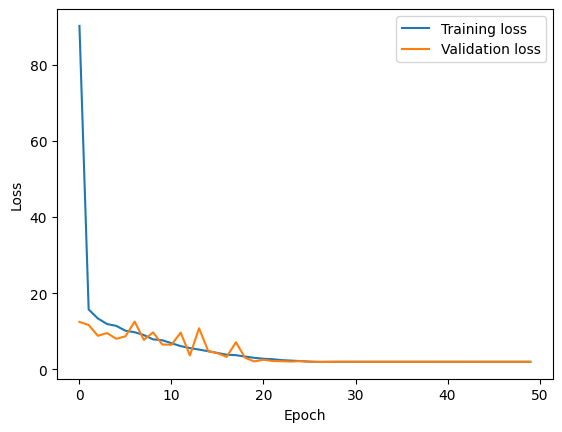

In [21]:
# plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(train_loss_hist, label='Training loss')
plt.plot(valid_loss_hist, label='Validation loss')
# set the x-axis to be in terms of epochs
plt.xlabel('Epoch')
plt.ylabel('Loss')
# set the y-axis max to 400
plt.legend()
plt.show()

In [22]:
# test the model
model.eval()
with torch.no_grad():
    test_loss = 0
    correct = 0
    total = 0
    for x, y in test_loader:
        y_pred = model(x)
        test_loss += criterion(y_pred, y)
        predicted = torch.argmax(y_pred, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
    print(f"Test Loss: {test_loss.item()/len(test_loader)}")
    print(f"Test Accuracy: {correct / total}")

Test Loss: 2.0010919221408705
Test Accuracy: 0.218242910998197


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# Load data directly from the CSV file
data = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")

# Features to drop that are non-numeric or identifiers
columns_to_drop = ['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name']
data = data.drop(columns=columns_to_drop, errors='ignore')

# Select the target columns
features = data.drop(columns=['track_genre', 'mode'], errors='ignore')
target_genre = data['track_genre']
target_mode = data['mode']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [ ]:
# Apply PCA for dimensionality reduction (retain 95% of variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance)
print(f"Number of components selected: {pca.n_components_}")

# PCA-transformed features
print("PCA-transformed features shape:", X_pca.shape)

# Optimize KMeans clustering using sampling
sample_size = 10000  # Adjust the sample size as needed
if X_pca.shape[0] > sample_size:
    sampled_indices = np.random.choice(X_pca.shape[0], size=sample_size, replace=False)
    X_pca_sampled = X_pca[sampled_indices]
else:
    X_pca_sampled = X_pca

In [ ]:
# Visualization: Original vs PCA-transformed Data (First 2 Dimensions)
plt.figure(figsize=(12, 6))

# Plot the original data (first 2 dimensions)
plt.subplot(1, 2, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], alpha=0.5, label="Original Data")
plt.title("Original Data (First 2 Dimensions)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

# Plot the PCA-transformed data (first 2 components)
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, label="PCA Data", color='orange')
plt.title("PCA-Transformed Data (First 2 Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Perform KMeans clustering
num_clusters = 3  # Choose the number of clusters (can be tuned)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# Evaluate clustering with silhouette score
silhouette_avg = silhouette_score(X_pca, kmeans_labels)
print(f"Silhouette Score for KMeans Clustering: {silhouette_avg}")

In [ ]:
# Visualization: KMeans clustering on PCA-transformed data
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.5)
plt.title("KMeans Clustering on PCA-Transformed Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster Label")
plt.show()

In [ ]:
# Split the data for genre classification
X_train_genre, X_test_genre, y_train_genre, y_test_genre = train_test_split(X_pca, target_genre, test_size=0.3, random_state=42)

# Initialize classifiers
knn_genre = KNeighborsClassifier()
decision_tree_genre = DecisionTreeClassifier(random_state=42)
random_forest_genre = RandomForestClassifier(n_estimators=10, random_state=42)

# Train and evaluate KNN for genre
knn_genre.fit(X_train_genre, y_train_genre)
knn_genre_predictions = knn_genre.predict(X_test_genre)
knn_genre_accuracy = accuracy_score(y_test_genre, knn_genre_predictions)
print("KNN Genre Accuracy:", knn_genre_accuracy)

# Train and evaluate Decision Tree for genre
decision_tree_genre.fit(X_train_genre, y_train_genre)
dt_genre_predictions = decision_tree_genre.predict(X_test_genre)
dt_genre_accuracy = accuracy_score(y_test_genre, dt_genre_predictions)
print("Decision Tree Genre Accuracy:", dt_genre_accuracy)

# Train and evaluate Random Forest for genre
random_forest_genre.fit(X_train_genre, y_train_genre)
rf_genre_predictions = random_forest_genre.predict(X_test_genre)
rf_genre_accuracy = accuracy_score(y_test_genre, rf_genre_predictions)
print("Random Forest Genre Accuracy:", rf_genre_accuracy)

# Split the data for mode classification
X_train_mode, X_test_mode, y_train_mode, y_test_mode = train_test_split(X_pca, target_mode, test_size=0.3, random_state=42)

# Train and evaluate KNN for mode
knn_mode = KNeighborsClassifier()
knn_mode.fit(X_train_mode, y_train_mode)
knn_mode_predictions = knn_mode.predict(X_test_mode)
knn_mode_accuracy = accuracy_score(y_test_mode, knn_mode_predictions)
print("KNN Mode Accuracy:", knn_mode_accuracy)

# Train and evaluate Decision Tree for mode
decision_tree_mode = DecisionTreeClassifier(random_state=42)
decision_tree_mode.fit(X_train_mode, y_train_mode)
dt_mode_predictions = decision_tree_mode.predict(X_test_mode)
dt_mode_accuracy = accuracy_score(y_test_mode, dt_mode_predictions)
print("Decision Tree Mode Accuracy:", dt_mode_accuracy)

# Train and evaluate Random Forest for mode
random_forest_mode = RandomForestClassifier(n_estimators=10, random_state=42)
random_forest_mode.fit(X_train_mode, y_train_mode)
rf_mode_predictions = random_forest_mode.predict(X_test_mode)
rf_mode_accuracy = accuracy_score(y_test_mode, rf_mode_predictions)
print("Random Forest Mode Accuracy:", rf_mode_accuracy)
